# GISANS with XYZ-polarization analysis

Model is a cylindrical disc of FeGe on a silicon substrate. The particles are not correlated on the surface with 1% surface filling.

The magnetization profile is taken from mircromagnetic simulations with 1 nm³ resolution and included in the BornAgain model as one compound particle with cubical shape.
As magnetic modulation in z-direction is relatively low this is later replace by cuboids with full height and average magnetization to speed up the calculation.

In [1]:
%pylab inline
from time import time
import bornagain as ba
from bornagain import deg, nm, R3
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create color maps for different log-scales with every decate having its own color

# combine them and build a new colormap
colors = np.vstack([cm.Blues_r(np.linspace(0., 1, 128)), cm.Reds_r(np.linspace(0., 1, 128)), 
                    cm.Greys_r(np.linspace(0., 1, 128))])
deccol3 = LinearSegmentedColormap.from_list('deccol3', colors)
colors = np.vstack([cm.Purples_r(np.linspace(0., 1, 128)), cm.Greens_r(np.linspace(0., 1, 128)), 
                    cm.Oranges_r(np.linspace(0., 1, 128)), cm.Greys_r(np.linspace(0., 1, 128))])
deccol4 = LinearSegmentedColormap.from_list('deccol4', colors)

COLORMAPS = {3: deccol3, 4: deccol4, 5: 'tab20c'}

In [3]:
def plot_result(result, add2=None, div2=None, Imin=1e-9, decades=5):
    Imax=10**decades*Imin
    ax = gca()
    if div2 is None:
        if add2 is None:
            I=result.array()
        else:
            I=result.array()+add2.array()
        imshow(I, cmap=COLORMAPS[decades], norm=LogNorm(Imin, Imax), 
               extent=list(result.axisMinMax(0, ))+list(result.axisMinMax(1)))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = colorbar(cax=cax)
    else:
        dI=result.array()-div2.array()
        Isign = sign(dI)
        Ilog = log10(maximum(Imin/Imax, abs(dI)/Imax))+decades
        I = Isign * Ilog
        imshow(I, cmap='seismic', vmin=-decades, vmax=decades,
               extent=list(result.axisMinMax(0, ))+list(result.axisMinMax(1)))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = colorbar(ticks=list(range(-decades, decades+1)), cax=cax)
        dec_min = int(log10(Imin))
        cbar.ax.set_yticklabels(['- 10$^{%i}$'%(dec_min+i) for i in range(decades, 0, -1)]+["|$\\Delta$|<10$^{%i}$"%dec_min]+
                                ['+ 10$^{%i}$'%(dec_min+i) for i in range(1, decades+1)])
        
    ax.set_xlabel(result.nameOfAxis(0).replace("_f", "$_f$").replace('phi', '$\\phi$'))
    ax.set_ylabel(result.nameOfAxis(1).replace("_f", "$_f$").replace('alpha', '$\\alpha$'))

In [4]:
import zipfile
ARCHIVE = 'FeGe.zip'
Ms=384_000 # A/m

def read_mm(fname):
    archive = zipfile.ZipFile(ARCHIVE)
    txt = archive.open(fname+'/m000000.gplot', 'r').read().decode('utf-8')
    data = [li.strip().split() for li in txt.splitlines() if li.strip()!='']
    adata= array(data, dtype=float).T
    nx = unique(adata[0]).shape[0]
    ny = unique(adata[1]).shape[0]
    nz = unique(adata[2]).shape[0]
    adata[3:6]*=Ms
    adata=adata.reshape(adata.shape[0], nz, ny, nx)
    return adata.transpose(0, 3, 2, 1)

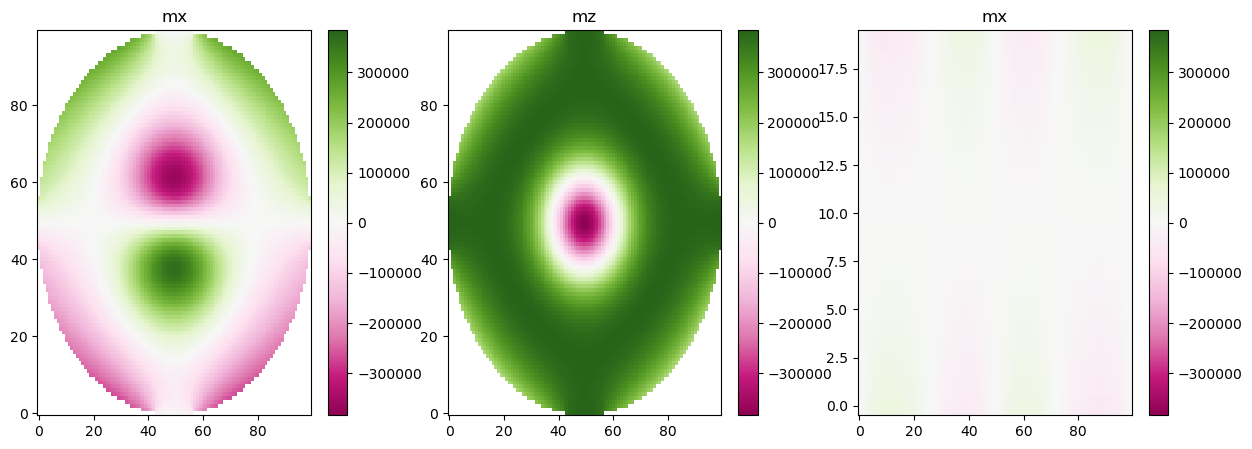

In [5]:
x,y,z,mx,my,mz=read_mm('dia_100')
R=50*nm

figure(figsize=(15,5))
subplot(131)
title('mx')
I = mx.mean(axis=2)
I[I==0] = np.nan
pcolormesh(x[:,:,0]*1e9, y[:,:,0]*1e9, I, cmap='PiYG', vmin=-Ms, vmax=Ms)
colorbar()
subplot(132)
title('mz')
I = mz.mean(axis=2)
I[I==0] = np.nan
pcolormesh(x[:,:,0]*1e9, y[:,:,0]*1e9, I, cmap='PiYG', vmin=-Ms, vmax=Ms)
colorbar()
subplot(133)
title('mx')
pcolormesh(x[:,0,:]*1e9, z[:,0,:]*1e9, mx.mean(axis=1), cmap='PiYG', vmin=-Ms, vmax=Ms)
colorbar();

In [6]:
xlat=x[:,0,0]*1e9*nm;ylat=y[0,:,0]*1e9*nm;zlat=z[0,0,:]*1e9*nm
xlat

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [7]:
def get_sample():
    material_vacuum = ba.MaterialBySLD("Vacuum", 0, 0)
    material_substrate = ba.MaterialBySLD("Substrate", 2e-6, 0e-8)

    toplayer = ba.Layer(material_vacuum)
    substrate = ba.Layer(material_substrate)

    # creates an empty particle composition
    composition = ba.Compound()
    
    dx = xlat[1]-xlat[0]
    dy = ylat[1]-ylat[0]
    dz = zlat[1]-zlat[0]
    
    ff = ba.Box(dx, dy, dz)
    
    for xi,xp in enumerate(xlat):
        for yi,yp in enumerate(ylat):
            for zi, zp in enumerate(zlat):
                Mxyz = R3(mx[xi,yi,zi], my[xi,yi,zi], mz[xi,yi,zi])
                if abs(array([mx[xi,yi,zi], my[xi,yi,zi], mz[xi,yi,zi]])).sum()==0.:
                    # ignore empty cells
                    continue
                material = ba.MaterialBySLD("cube_%i_%i_%i"%(xi,yi,zi), 4.4e-6, 0.00033e-6, Mxyz)
                particle = ba.Particle(material, ff.clone())
                composition.addComponent(particle, R3(xp, yp, zp))

    layout = ba.ParticleLayout(composition)
    layout.setTotalParticleSurfaceDensity(0.01/(2*R)**2) # 1/nm² - 1% surface filling in square lattice
    toplayer.addLayout(layout)

    sample = ba.MultiLayer()
    sample.addLayer(toplayer)
    sample.addLayer(substrate)
    return sample

def get_sample_2d():
    material_vacuum = ba.MaterialBySLD("Vacuum", 0, 0)
    material_substrate = ba.MaterialBySLD("Substrate", 2e-6, 0e-8)

    toplayer = ba.Layer(material_vacuum)
    substrate = ba.Layer(material_substrate)

    # creates an empty particle composition
    composition = ba.Compound()
    
    dx = xlat[1]-xlat[0]
    dy = ylat[1]-ylat[0]
    dz = (zlat[1]-zlat[0])*(zlat.shape[0]+1)
    
    ff = ba.Box(dx, dy, dz)
    
    for xi,xp in enumerate(xlat):
        for yi,yp in enumerate(ylat):
                Mxyz = R3(mx[xi,yi].mean(), my[xi,yi].mean(), mz[xi,yi].mean())
                if abs(array([mx[xi,yi,0], my[xi,yi,0], mz[xi,yi,0]])).sum()==0.:
                    # ignore empty cells
                    continue
                material = ba.MaterialBySLD("cube_%i_%i"%(xi,yi), 4.4e-6, 0.00033e-6, Mxyz)
                particle = ba.Particle(material, ff.clone())
                composition.addComponent(particle, R3(xp, yp, 0))

    layout = ba.ParticleLayout(composition)
    layout.setTotalParticleSurfaceDensity(0.01/(2*R)**2) # 1/nm² - 1% surface filling in square lattice
    toplayer.addLayout(layout)

    sample = ba.MultiLayer()
    sample.addLayer(toplayer)
    sample.addLayer(substrate)
    return sample

def get_reference():
    # single particle with same dimensions and homogeneous magnetization
    material_vacuum = ba.MaterialBySLD("Vacuum", 0, 0)
    material_substrate = ba.MaterialBySLD("Substrate", 2e-6, 0e-8)
    material_particle = ba.MaterialBySLD("Particle", 4.4e-6, 0.00033e-6, R3(0, 0, mx.max()))

    toplayer = ba.Layer(material_vacuum)
    substrate = ba.Layer(material_substrate)

    ff = ba.Cylinder(R, 20*nm)
    
    particle = ba.Particle(material_particle, ff.clone())
    layout = ba.ParticleLayout(particle)
    layout.setTotalParticleSurfaceDensity(0.01/(2*R)**2) # 1/nm² - 1% surface filling in square lattice
    toplayer.addLayout(layout)

    sample = ba.MultiLayer()
    sample.addLayer(toplayer)
    sample.addLayer(substrate)
    return sample

def get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1), n=30):
    beam = ba.Beam(1.0, 0.4*nm, 0.2*deg)
    beam.setPolarization(pol)
    detector = ba.SphericalDetector(n, -1*deg, 1*deg, n, 0, 2*deg)
    detector.setAnalyzer(ana, 1, 0.5)
    simulation = ba.ScatteringSimulation(beam, sample, detector)
    return simulation


In [8]:
start=time()

reference = get_reference()
sample = get_sample()

simulation = get_simulation(reference, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
resref_pp = simulation.simulate()
simulation = get_simulation(reference, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
resref_mm = simulation.simulate()

simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result_pp = simulation.simulate()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result_mm = simulation.simulate()

print(time()-start)

1181.3846998214722


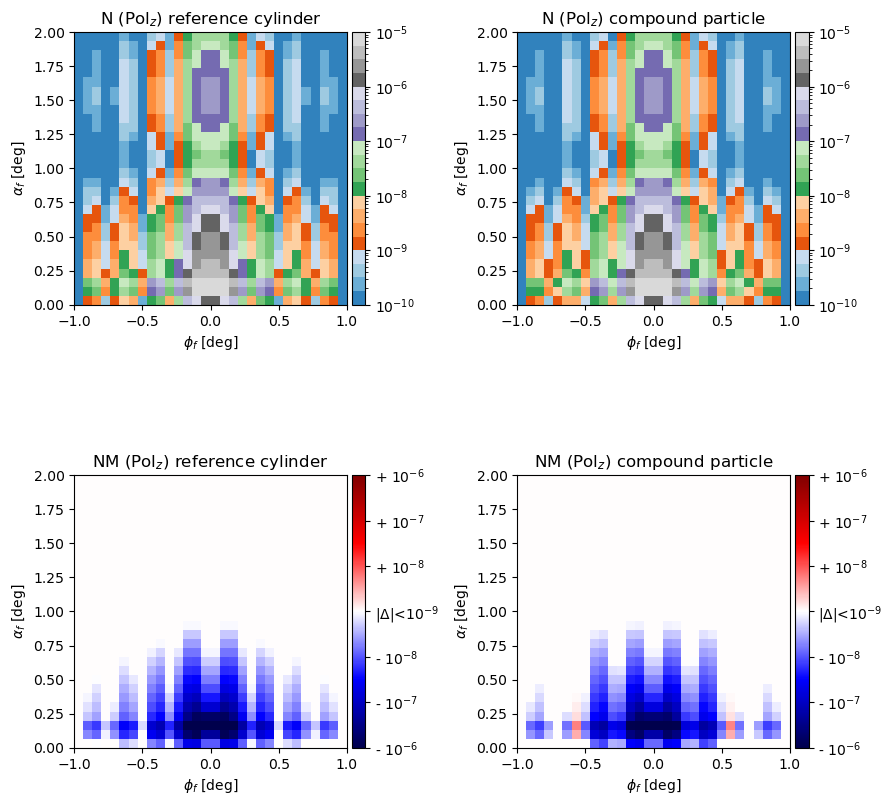

In [28]:
figure(figsize=(9,9))
subplot(221)
title('N (Pol$_z$) reference cylinder')
plot_result(resref_pp, add2=resref_mm, Imin=1e-10)

subplot(222)
title('N (Pol$_z$) compound particle')
plot_result(result_pp, add2=result_mm, Imin=1e-10)

subplot(223)
title('NM (Pol$_z$) reference cylinder')
plot_result(resref_pp, div2=resref_mm, Imin=1e-9, decades=3)

subplot(224)
title('NM (Pol$_z$) compound particle')
plot_result(result_pp, div2=result_mm, Imin=1e-9, decades=3)

tight_layout(pad=1.0)

In [10]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().setNumberOfThreads(8)
result_udx = simulation.simulate()

In [11]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result_dux = simulation.simulate()

In [12]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result_udy = simulation.simulate()

In [13]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result_duy = simulation.simulate()

In [14]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result_udz = simulation.simulate()

In [15]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result_duz = simulation.simulate()

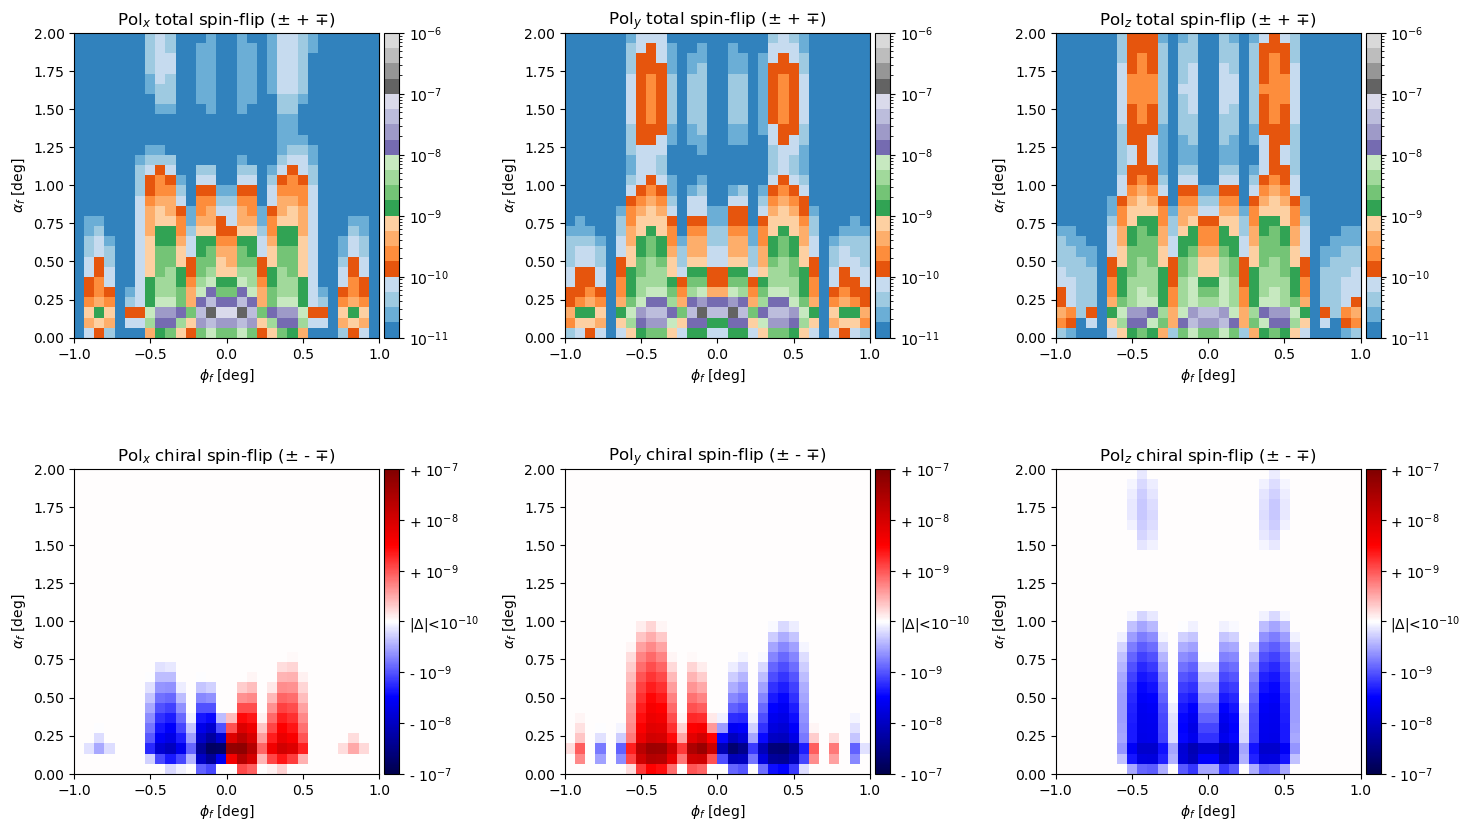

In [32]:
figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ total spin-flip (± + ∓)')
plot_result(result_udx, add2=result_dux, Imin=1e-11)
subplot(232)
title('Pol$_y$ total spin-flip (± + ∓)')
plot_result(result_udy, add2=result_duy, Imin=1e-11)
subplot(233)
title('Pol$_z$ total spin-flip (± + ∓)')
plot_result(result_udz, add2=result_duz, Imin=1e-11)

subplot(234)
title('Pol$_x$ chiral spin-flip (± - ∓)')
plot_result(result_udx, div2=result_dux, Imin=1e-10, decades=3)
subplot(235)
title('Pol$_y$ chiral spin-flip (± - ∓)')
plot_result(result_udy, div2=result_duy, Imin=1e-10, decades=3)
subplot(236)
title('Pol$_z$ chiral spin-flip (± - ∓)')
plot_result(result_udz, div2=result_duz, Imin=1e-10, decades=3)

tight_layout(pad=2.0)

In [17]:
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().setNumberOfThreads(8)
result100_udx = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result100_dux = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result100_udy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result100_duy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result100_udz = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result100_duz = simulation.simulate()

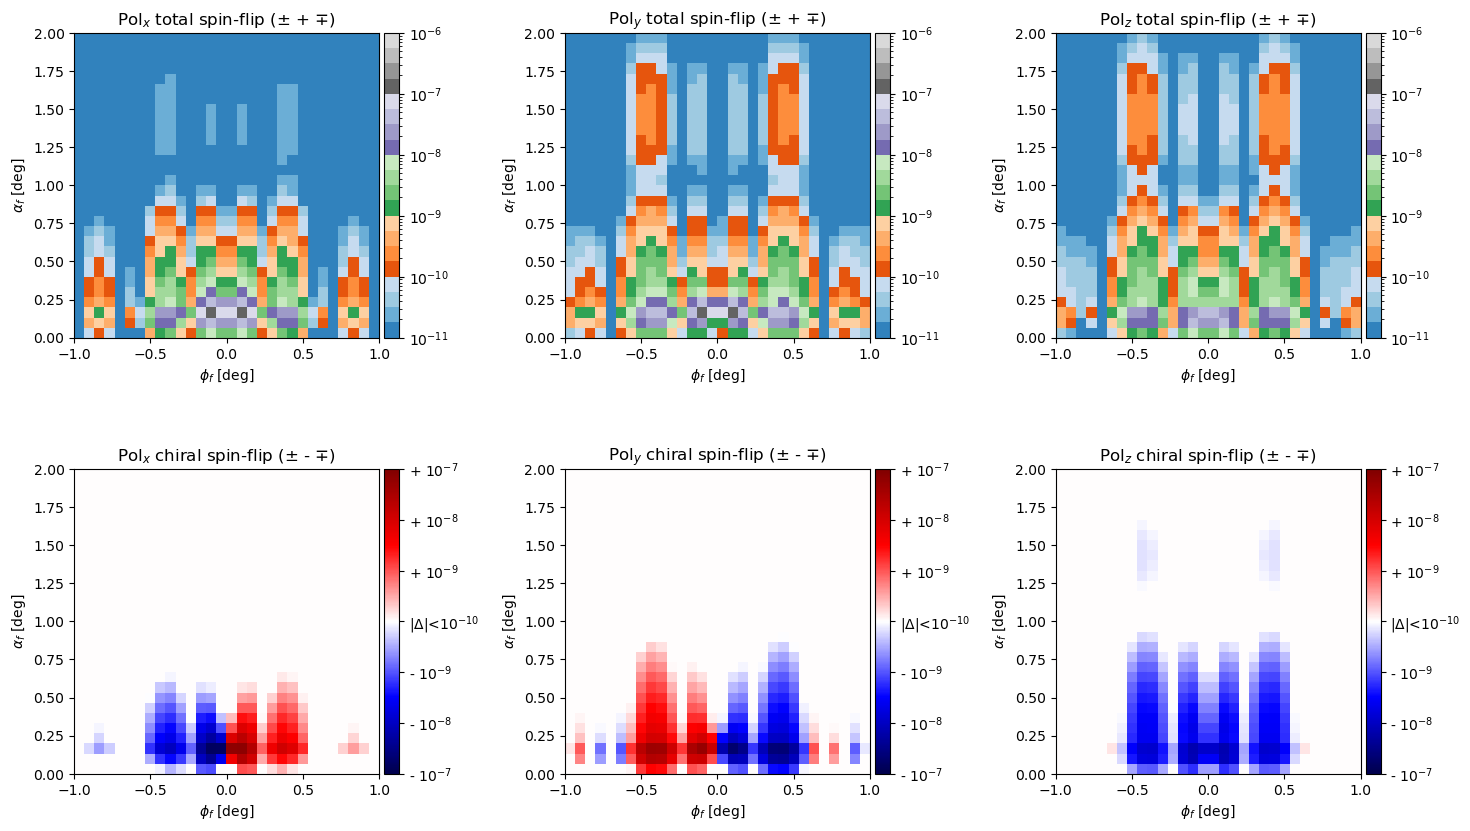

In [33]:
figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ total spin-flip (± + ∓)')
plot_result(result100_udx, add2=result100_dux, Imin=1e-11)
subplot(232)
title('Pol$_y$ total spin-flip (± + ∓)')
plot_result(result100_udy, add2=result100_duy, Imin=1e-11)
subplot(233)
title('Pol$_z$ total spin-flip (± + ∓)')
plot_result(result100_udz, add2=result100_duz, Imin=1e-11)

subplot(234)
title('Pol$_x$ chiral spin-flip (± - ∓)')
plot_result(result100_udx, div2=result100_dux, Imin=1e-10, decades=3)
subplot(235)
title('Pol$_y$ chiral spin-flip (± - ∓)')
plot_result(result100_udy, div2=result100_duy, Imin=1e-10, decades=3)
subplot(236)
title('Pol$_z$ chiral spin-flip (± - ∓)')
plot_result(result100_udz, div2=result100_duz, Imin=1e-10, decades=3)

tight_layout(pad=2.0)

In [19]:
x,y,z,mx,my,mz=read_mm('dia_60')
R=30*nm
xlat=x[:,0,0]*1e9*nm;ylat=y[0,:,0]*1e9*nm;zlat=z[0,0,:]*1e9*nm

In [20]:
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().setNumberOfThreads(8)
result60_udx = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result60_dux = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result60_udy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result60_duy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result60_udz = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result60_duz = simulation.simulate()

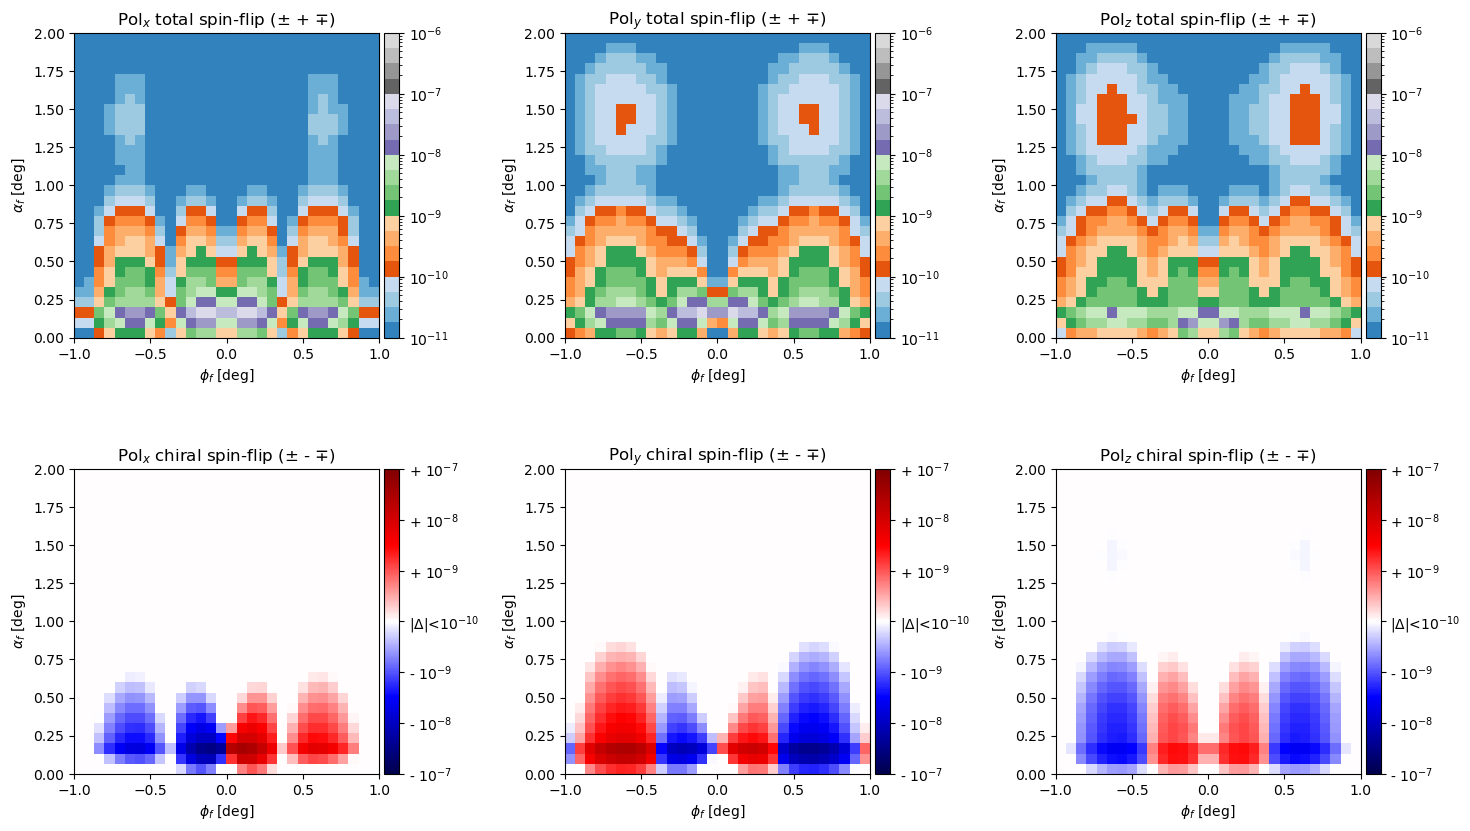

In [34]:
figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ total spin-flip (± + ∓)')
plot_result(result60_udx, add2=result60_dux, Imin=1e-11)
subplot(232)
title('Pol$_y$ total spin-flip (± + ∓)')
plot_result(result60_udy, add2=result60_duy, Imin=1e-11)
subplot(233)
title('Pol$_z$ total spin-flip (± + ∓)')
plot_result(result60_udz, add2=result60_duz, Imin=1e-11)

subplot(234)
title('Pol$_x$ chiral spin-flip (± - ∓)')
plot_result(result60_udx, div2=result60_dux, Imin=1e-10, decades=3)
subplot(235)
title('Pol$_y$ chiral spin-flip (± - ∓)')
plot_result(result60_udy, div2=result60_duy, Imin=1e-10, decades=3)
subplot(236)
title('Pol$_z$ chiral spin-flip (± - ∓)')
plot_result(result60_udz, div2=result60_duz, Imin=1e-10, decades=3)

tight_layout(pad=2.0)

In [22]:
x,y,z,mx,my,mz=read_mm('dia_200')
R=100*nm
xlat=x[:,0,0]*1e9*nm;ylat=y[0,:,0]*1e9*nm;zlat=z[0,0,:]*1e9*nm

In [23]:
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().setNumberOfThreads(8)
result200_udx = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result200_dux = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result200_udy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result200_duy = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result200_udz = simulation.simulate()
sample = get_sample_2d()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result200_duz = simulation.simulate()

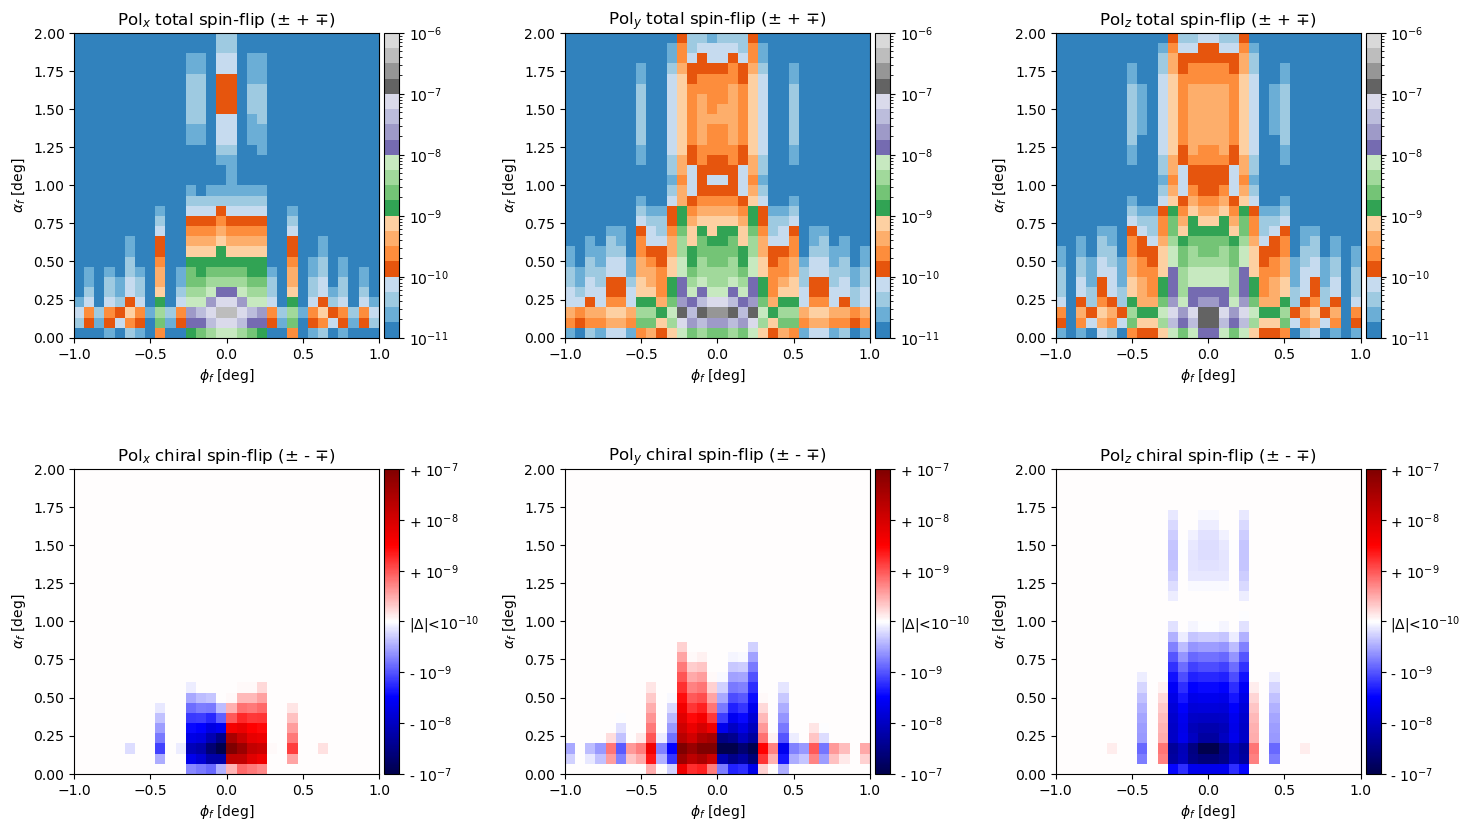

In [24]:
figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ total spin-flip (± + ∓)')
plot_result(result200_udx, add2=result200_dux, Imin=1e-11)
subplot(232)
title('Pol$_y$ total spin-flip (± + ∓)')
plot_result(result200_udy, add2=result200_duy, Imin=1e-11)
subplot(233)
title('Pol$_z$ total spin-flip (± + ∓)')
plot_result(result200_udz, add2=result200_duz, Imin=1e-11)

subplot(234)
title('Pol$_x$ chiral spin-flip (± - ∓)')
plot_result(result200_udx, div2=result200_dux, Imin=1e-10, decades=3)
subplot(235)
title('Pol$_y$ chiral spin-flip (± - ∓)')
plot_result(result200_udy, div2=result200_duy, Imin=1e-10, decades=3)
subplot(236)
title('Pol$_z$ chiral spin-flip (± - ∓)')
plot_result(result200_udz, div2=result200_duz, Imin=1e-10, decades=3)

tight_layout(pad=2.0)